In [113]:
# uncomment to install all requirements
# !pip install -r requirements.txt

In [114]:
import mujoco
import mediapy as media
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation as R
import gymnasium as gym
from stable_baselines3 import DDPG

In [115]:
model = mujoco.MjModel.from_xml_path("bitcraze_crazyflie_2/cf2.xml")

In [116]:
data = mujoco.MjData(model)

""

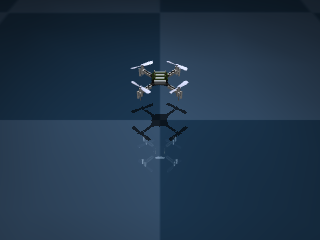

In [117]:
with mujoco.Renderer(model) as renderer:
  mujoco.mj_forward(model, data)
  renderer.update_scene(data)

  media.show_image(renderer.render())

In [118]:
# define mass
model.body('cf2').mass[0]

np.float64(0.0347)

<h1 style="color:navy; text-decoration:underline;">PD Controller</h1>


In [119]:
def feedback_control(data):
    kp = 3.0
    kd = 1.0
    pos_desired = np.array([0.0, 0.0, 0.5])
    vel_desired = np.array([0.0, 0.0, 0.0])

    pos_error = pos_desired - data.qpos[0:3]
    vel_error = vel_desired - data.qvel[0:3]
    
    m = model.body('cf2').mass[0]
    force = kp * pos_error + kd * vel_error + np.array([0, 0, 9.81])
    thrust = m * force[2]  # only z-component

    return thrust

In [120]:
duration = 20  # (seconds)
framerate = 60  # (Hz)

# simulate and display video.
frames = []
t_l = []
qpos_l = []
qori_l = []

mujoco.mj_resetData(model, data)  # reset state and time.
with mujoco.Renderer(model, height = 480, width = 640) as renderer:
  while data.time < duration:
    data.actuator('body_thrust').ctrl = feedback_control(data)  # set body thrust (f_z) to hover
    mujoco.mj_step(model, data)
    if len(frames) < data.time * framerate:
      t_l.append(data.time)
      qpos_l.append(data.qpos.copy())
      qori_l.append(R.from_quat(data.qpos[3:7], scalar_first=True).as_euler('xyz'))

      renderer.update_scene(data, camera = 'track')
      pixels = renderer.render()
      frames.append(pixels)

t_l = np.array(t_l)
qpos_l = np.array(qpos_l)
qori_l = np.array(qori_l)
media.show_video(frames, fps=framerate)

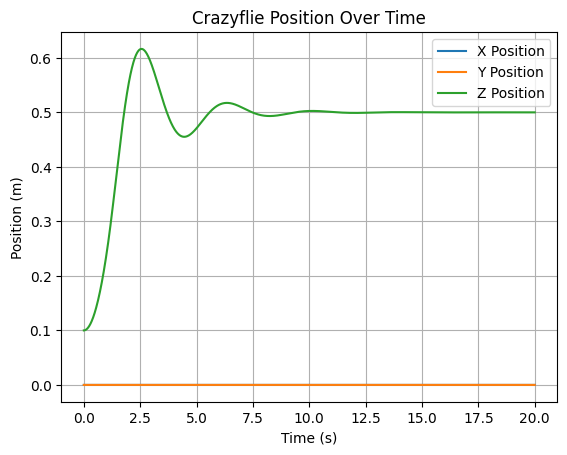

In [121]:
plt.plot(t_l, qpos_l[:, 0], label ="X Position")
plt.plot(t_l, qpos_l[:, 1], label ="Y Position")
plt.plot(t_l, qpos_l[:, 2], label ="Z Position")
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.grid()
plt.title("Crazyflie Position Over Time")
plt.legend()

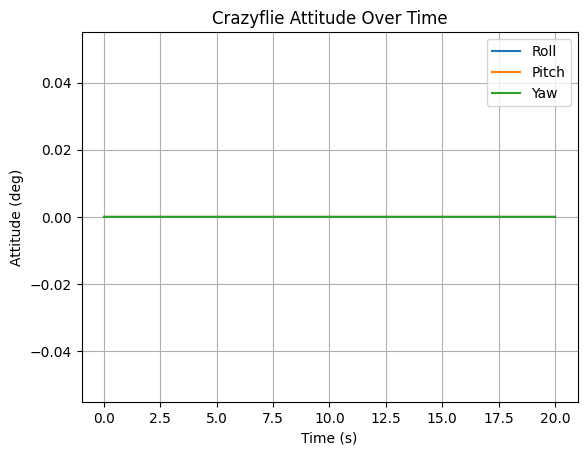

In [122]:
plt.plot(t_l, np.degrees(qori_l[:, 0]), label ="Roll") 
plt.plot(t_l, np.degrees(qori_l[:, 1]), label ="Pitch")
plt.plot(t_l, np.degrees(qori_l[:, 2]), label ="Yaw")
plt.xlabel("Time (s)")
plt.ylabel("Attitude (deg)")
plt.grid()
plt.title("Crazyflie Attitude Over Time")
plt.legend()

RMS Position Error (m): 0.08986894438714838


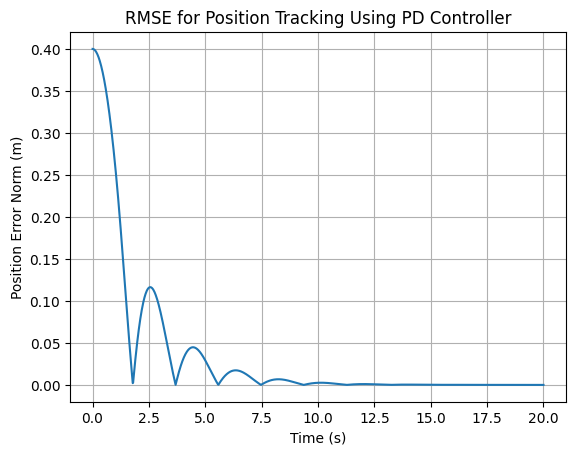

In [123]:
desired_pos = np.array([0.0, 0.0, 0.5])
error_norm = np.linalg.norm(qpos_l[:,:3] - desired_pos, axis = 1)
rms_error = np.sqrt(np.mean(error_norm**2))
plt.plot(t_l, error_norm)
plt.xlabel("Time (s)")
plt.ylabel("Position Error Norm (m)")
plt.grid()
plt.title("RMSE for Position Tracking Using PD Controller")
print("RMS Position Error (m):", rms_error)

<h1 style="color:navy; text-decoration:underline;">
Controller Based on the Lab 5 C Code for the Crazyflie Drone (Without Integral Action)
</h1>

In [124]:
# working hover code from C code:

# in integer format, has to be remapped to limits

# tau_x = 0.00491541f * (p_y - p_y_des) -0.00652343f * phi + 0.00264962f * v_y -0.00084121f * w_x;
# tau_y = -0.00491541f * (p_x - p_x_des) -0.00654763f * theta -0.00265419f * v_x -0.00084713f * w_y;
# tau_z = -0.00010906f * psi -0.00009983f * w_z;
# f_z = -0.17624202f * (p_z - p_z_des) -0.10988951f * v_z + 0.32373000f;

In [125]:
# original C code from Lab 5 controller:

def enforce_motor_limits(motor_commands):
    motor_commands = np.clip(motor_commands, [-1, -1, -1, 0], [1, 1, 1, 0.35])
    return motor_commands

def c_controller(data, desired_pos):
    p_x_des, p_y_des, p_z_des = desired_pos

    p_x, p_y, p_z = data.qpos[0:3]
    v_x, v_y, v_z = data.qvel[0:3]
    w_x, w_y, w_z = data.qvel[3:6]
    phi, theta, psi = R.from_quat(data.qpos[3:7], scalar_first=True).as_euler('xyz')

    tau_x = 0.00491541 * (p_y - p_y_des) -0.00652343 * phi + 0.00264962 * v_y -0.00084121 * w_x
    tau_y = -0.00491541 * (p_x - p_x_des) -0.00654763 * theta -0.00265419 * v_x -0.00084713 * w_y
    tau_z = -0.00010906 * psi -0.00009983 * w_z
    # original f_z from C code:
    f_z = -0.17624202 * (p_z - p_z_des) -0.10988951 * v_z + 0.32373000
    # adjusted f_z to account for steady state error observed:
    # f_z = -0.17624202 * (p_z - p_z_des) -0.10988951 * v_z + model.body('cf2').mass[0] * 9.81

    return enforce_motor_limits([tau_x, tau_y, tau_z, f_z])

    # do not need lines below because they are used simply for mapping onto cf2 motors

    # m_1 = -4676393.6 * tau_x -4676393.6 * tau_y -78864353.3 * tau_z + 154321.0 * f_z
    # m_2 = -4676393.6 * tau_x + 4676393.6 * tau_y + 78864353.3 * tau_z + 154321.0 * f_z
    # m_3 = 4676393.6 * tau_x + 4676393.6 * tau_y -78864353.3 * tau_z + 154321.0 * f_z
    # m_4 = 4676393.6 * tau_x -4676393.6 * tau_y + 78864353.3 * tau_z + 154321.0 * f_z

    # motor_commands = np.array([m_1, m_2, m_3, m_4])
    # motor_commands = np.clip(motor_commands, 0, 65535)


In [126]:
# controller based on C code:

duration = 20  # (seconds)
framerate = 60  # (Hz)

# simulate and display video.
frames = []
t_l = []
qpos_l = []
qori_l = []
u_l = []

mujoco.mj_resetData(model, data)  # reset state and time.
with mujoco.Renderer(model, height = 480, width = 640) as renderer:
    while data.time < duration:

        u = c_controller(data, desired_pos = np.array([0.0, 0.0, 0.5]))
        data.actuator('x_moment').ctrl = u[0]
        data.actuator('y_moment').ctrl = u[1]
        data.actuator('z_moment').ctrl = u[2]
        data.actuator('body_thrust').ctrl = u[3]
        

        mujoco.mj_step(model, data)
        if len(frames) < data.time * framerate:
            t_l.append(data.time)
            qpos_l.append(data.qpos.copy())
            qori_l.append(R.from_quat(data.qpos[3:7], scalar_first=True).as_euler('xyz'))
            u_l.append(u)

            renderer.update_scene(data, camera = 'track')
            pixels = renderer.render()
            frames.append(pixels)

t_l = np.array(t_l)
qpos_l = np.array(qpos_l)
qori_l = np.array(qori_l)
u_l = np.array(u_l)
media.show_video(frames, fps=framerate)

# The following plots show the controller without the integral action

## Note: Using the controller from Lab 5, we see that there is a steady state error (also observed by the drone in real life). Rather than reaching the desired position of $z = 0.5$ meters, the drone has a constant steady state error and only maintains an altitude of 0.4 meters. This prompts adding integral action or correcting for the bias in $f_z$ (it should be $mg$, but in the controller C code, it is smaller than that).

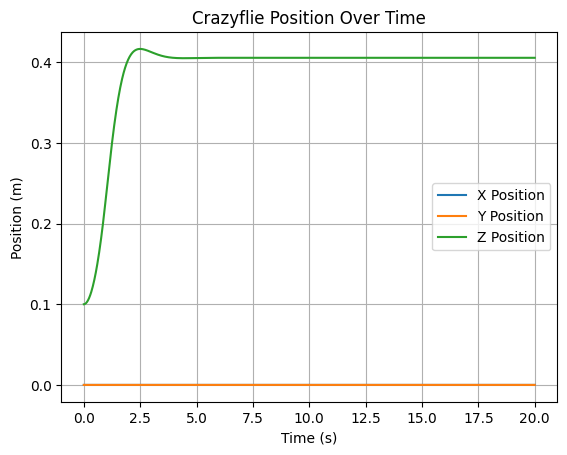

In [127]:
plt.plot(t_l, qpos_l[:, 0], label ="X Position")
plt.plot(t_l, qpos_l[:, 1], label ="Y Position")
plt.plot(t_l, qpos_l[:, 2], label ="Z Position")
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.grid()
plt.title("Crazyflie Position Over Time") 
plt.legend()

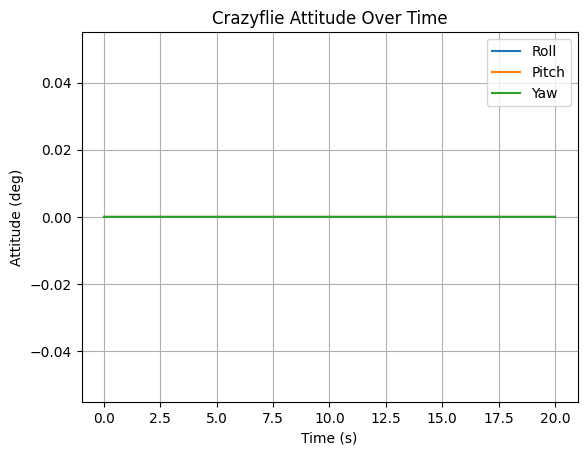

In [128]:
plt.plot(t_l, np.degrees(qori_l[:, 0]), label ="Roll") 
plt.plot(t_l, np.degrees(qori_l[:, 1]), label ="Pitch")
plt.plot(t_l, np.degrees(qori_l[:, 2]), label ="Yaw")
plt.xlabel("Time (s)")
plt.ylabel("Attitude (deg)")
plt.grid()
plt.title("Crazyflie Attitude Over Time")
plt.legend()

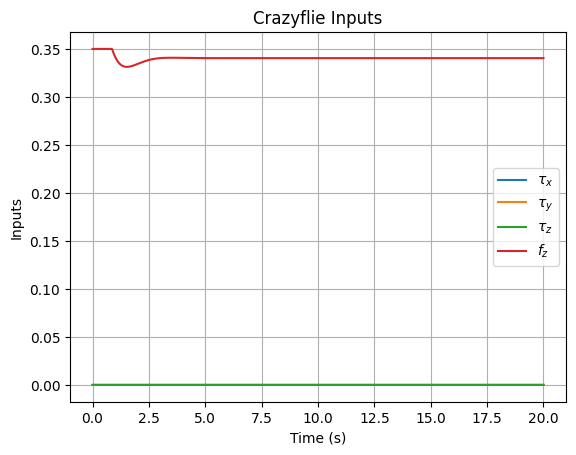

In [129]:
plt.plot(t_l, u_l[:, 0], label=r"$\tau_x$")
plt.plot(t_l, u_l[:, 1], label=r"$\tau_y$")
plt.plot(t_l, u_l[:, 2], label=r"$\tau_z$")
plt.plot(t_l, u_l[:, 3], label=r"$f_z$")
plt.xlabel("Time (s)")
plt.ylabel("Inputs")
plt.grid()
plt.title("Crazyflie Inputs")
plt.legend()


RMS Position Error (m) Without Integral Action: 0.1255830902904274


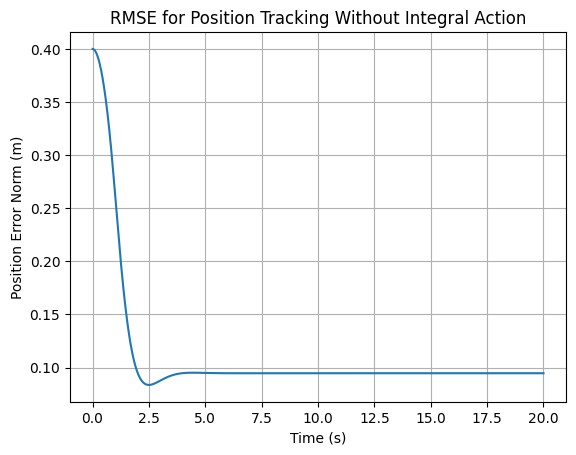

In [130]:
error_norm = np.linalg.norm(qpos_l[:,:3] - desired_pos, axis = 1)
rms_error = np.sqrt(np.mean(error_norm**2))
plt.plot(t_l, error_norm)
plt.xlabel("Time (s)")
plt.ylabel("Position Error Norm (m)")
plt.grid()
plt.title("RMSE for Position Tracking Without Integral Action")
print("RMS Position Error (m) Without Integral Action:", rms_error)

<h1 style="color:navy; text-decoration:underline;">
Plots showing the drone with integral action to correct the constant steady state error
</h1>


In [131]:
# original C code from Lab 5 -

def enforce_motor_limits(motor_commands):
    motor_commands = np.clip(motor_commands, [-1, -1, -1, 0], [1, 1, 1, 0.35]) # 0.35 is the motor limit in the .xml file
    return motor_commands

def c_controller(data, desired_pos):
    p_x_des, p_y_des, p_z_des = desired_pos

    p_x, p_y, p_z = data.qpos[0:3]
    v_x, v_y, v_z = data.qvel[0:3]
    w_x, w_y, w_z = data.qvel[3:6]
    phi, theta, psi = R.from_quat(data.qpos[3:7], scalar_first=True).as_euler('xyz')

    tau_x = 0.00491541 * (p_y - p_y_des) -0.00652343 * phi + 0.00264962 * v_y -0.00084121 * w_x
    tau_y = -0.00491541 * (p_x - p_x_des) -0.00654763 * theta -0.00265419 * v_x -0.00084713 * w_y
    tau_z = -0.00010906 * psi -0.00009983 * w_z
    # adjusted f_z to account for steady state error observed:
    f_z = -0.17624202 * (p_z - p_z_des) -0.10988951 * v_z + model.body('cf2').mass[0] * 9.81

    return enforce_motor_limits([tau_x, tau_y, tau_z, f_z])

    # do not need lines below bc used simply for mapping onto cf2 motors

    # m_1 = -4676393.6 * tau_x -4676393.6 * tau_y -78864353.3 * tau_z + 154321.0 * f_z
    # m_2 = -4676393.6 * tau_x + 4676393.6 * tau_y + 78864353.3 * tau_z + 154321.0 * f_z
    # m_3 = 4676393.6 * tau_x + 4676393.6 * tau_y -78864353.3 * tau_z + 154321.0 * f_z
    # m_4 = 4676393.6 * tau_x -4676393.6 * tau_y + 78864353.3 * tau_z + 154321.0 * f_z

    # motor_commands = np.array([m_1, m_2, m_3, m_4])
    # motor_commands = np.clip(motor_commands, 0, 65535)

In [132]:
# controller based on C code:

duration = 20  # (seconds)
framerate = 60  # (Hz)

# simulate and display video.
frames = []
t_l = []
qpos_l = []
qori_l = []
u_l = []

mujoco.mj_resetData(model, data)  # reset state and time.
with mujoco.Renderer(model, height = 480, width = 640) as renderer:
    while data.time < duration:

        u = c_controller(data, desired_pos = np.array([0.0, 0.0, 0.5]))
        data.actuator('x_moment').ctrl = u[0]
        data.actuator('y_moment').ctrl = u[1]
        data.actuator('z_moment').ctrl = u[2]
        data.actuator('body_thrust').ctrl = u[3]
        

        mujoco.mj_step(model, data)
        if len(frames) < data.time * framerate:
            t_l.append(data.time)
            qpos_l.append(data.qpos.copy())
            qori_l.append(R.from_quat(data.qpos[3:7], scalar_first=True).as_euler('xyz'))
            u_l.append(u)

            renderer.update_scene(data)
            pixels = renderer.render()
            frames.append(pixels)

t_l = np.array(t_l)
qpos_l = np.array(qpos_l)
qori_l = np.array(qori_l)
u_l = np.array(u_l)
media.show_video(frames, fps=framerate)

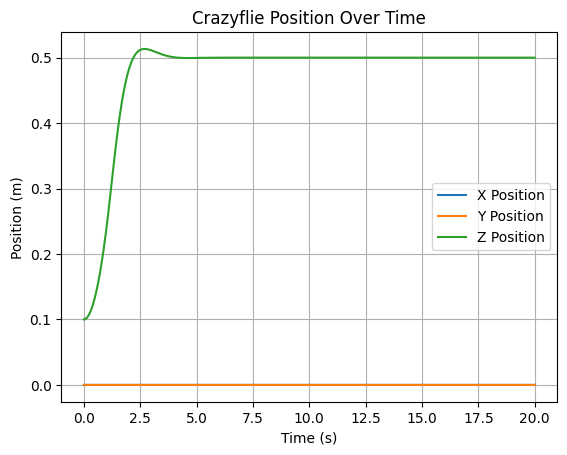

In [133]:
plt.plot(t_l, qpos_l[:, 0], label ="X Position")
plt.plot(t_l, qpos_l[:, 1], label ="Y Position")
plt.plot(t_l, qpos_l[:, 2], label ="Z Position")
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.grid()
plt.title("Crazyflie Position Over Time") 
plt.legend()

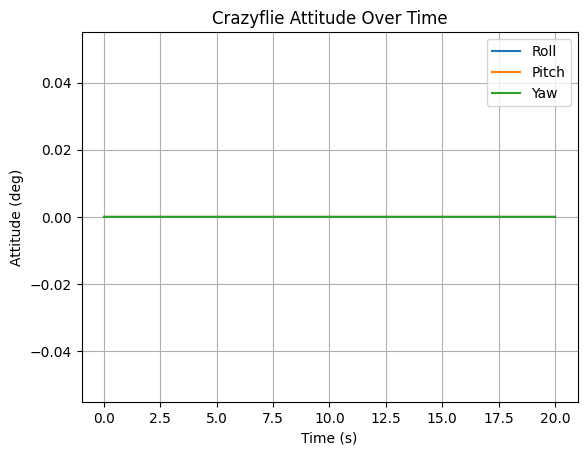

In [134]:
plt.plot(t_l, np.degrees(qori_l[:, 0]), label ="Roll") 
plt.plot(t_l, np.degrees(qori_l[:, 1]), label ="Pitch")
plt.plot(t_l, np.degrees(qori_l[:, 2]), label ="Yaw")
plt.xlabel("Time (s)")
plt.ylabel("Attitude (deg)")
plt.grid()
plt.title("Crazyflie Attitude Over Time")
plt.legend()

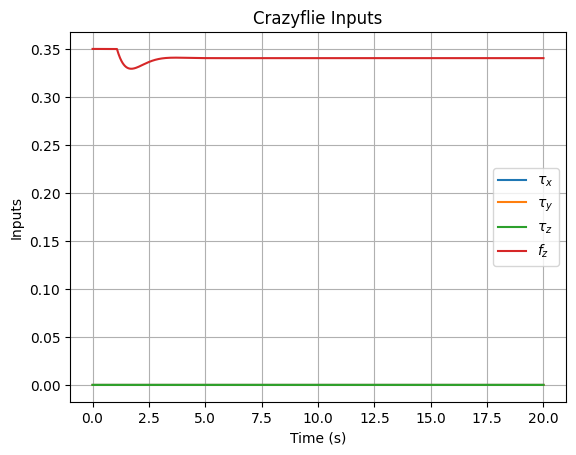

In [135]:
plt.plot(t_l, u_l[:, 0], label=r"$\tau_x$")
plt.plot(t_l, u_l[:, 1], label=r"$\tau_y$")
plt.plot(t_l, u_l[:, 2], label=r"$\tau_z$")
plt.plot(t_l, u_l[:, 3], label=r"$f_z$")
plt.grid()
plt.xlabel("Time (s)")
plt.ylabel("Inputs")
plt.title("Crazyflie Inputs")
plt.legend()

RMS Position Error (m) for the Custom Controller with Integral Action: 0.0862812838669387


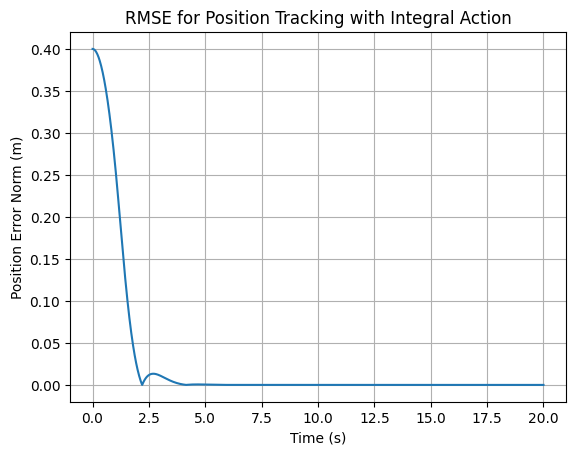

In [136]:
error_norm = np.linalg.norm(qpos_l[:,:3] - desired_pos, axis = 1)
rms_error = np.sqrt(np.mean(error_norm**2))
plt.plot(t_l, error_norm)
plt.xlabel("Time (s)")
plt.ylabel("Position Error Norm (m)")
plt.grid()
plt.title("RMSE for Position Tracking with Integral Action")
print("RMS Position Error (m) for the Custom Controller with Integral Action:", rms_error)

### As seen above, there is convergence with the RMSE of position tracking for the custom controller with integral action, showing minimal tracking error.

<h1 style="color:navy; text-decoration:underline;">
Testing the Robustness of the Lab 5 Controller By Introducing Perturbations
</h1>


In [137]:
def perturb_initial_state(data):
    # perturb orientation by small random angles

    angles = np.random.uniform(-0.01, 0.01, size=3)
    rot = R.from_euler('xyz', angles)
    current_rot = R.from_quat(data.qpos[3:7], scalar_first=True)
    new_rot = rot * current_rot
    data.qpos[3:7] = new_rot.as_quat(scalar_first=True)

In [138]:
def enforce_motor_limits(motor_commands):
    motor_commands = np.clip(motor_commands, [-1, -1, -1, 0], [1, 1, 1, 0.35]) # 0.35 is the motor limit in the .xml file
    return motor_commands

def c_controller(data, desired_pos):
    p_x_des, p_y_des, p_z_des = desired_pos

    p_x, p_y, p_z = data.qpos[0:3]
    v_x, v_y, v_z = data.qvel[0:3]
    w_x, w_y, w_z = data.qvel[3:6]
    phi, theta, psi = R.from_quat(data.qpos[3:7], scalar_first=True).as_euler('xyz')

    tau_x = 0.00491541 * (p_y - p_y_des) -0.00652343 * phi + 0.00264962 * v_y -0.00084121 * w_x
    tau_y = -0.00491541 * (p_x - p_x_des) -0.00654763 * theta -0.00265419 * v_x -0.00084713 * w_y
    tau_z = -0.00010906 * psi -0.00009983 * w_z
    # adjusted f_z to account for steady state error observed:
    f_z = -0.17624202 * (p_z - p_z_des) -0.10988951 * v_z + model.body('cf2').mass[0] * 9.81

    return enforce_motor_limits([tau_x, tau_y, tau_z, f_z])

In [139]:
duration = 20  # (seconds)
framerate = 60  # (Hz)

# simulate and display video.
frames = []
t_l = []
qpos_l = []
qori_l = []
u_l = []
desired_pos = np.array([0.0, 0.0, 0.5])

mujoco.mj_resetData(model, data)  # reset state and time.
perturb_initial_state(data)
with mujoco.Renderer(model, height = 480, width = 640) as renderer:
    while data.time < duration:

        u = c_controller(data, desired_pos)
        data.actuator('x_moment').ctrl = u[0] * -1e5
        data.actuator('y_moment').ctrl = u[1] * -1e5
        data.actuator('z_moment').ctrl = u[2] * -1e5
        data.actuator('body_thrust').ctrl = u[3]
        

        mujoco.mj_step(model, data)
        if len(frames) < data.time * framerate:
            t_l.append(data.time)
            qpos_l.append(data.qpos.copy())
            qori_l.append(R.from_quat(data.qpos[3:7], scalar_first=True).as_euler('xyz'))
            u_l.append(u)

            renderer.update_scene(data, camera = 'track')
            pixels = renderer.render()
            frames.append(pixels)

t_l = np.array(t_l)
qpos_l = np.array(qpos_l)
qori_l = np.array(qori_l)
u_l = np.array(u_l)
media.show_video(frames, fps=framerate)

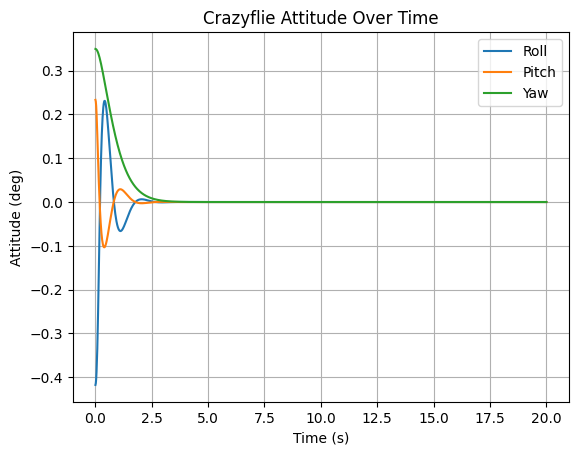

In [140]:
plt.plot(t_l, np.degrees(qori_l[:, 0]), label ="Roll") 
plt.plot(t_l, np.degrees(qori_l[:, 1]), label ="Pitch")
plt.plot(t_l, np.degrees(qori_l[:, 2]), label ="Yaw")
plt.xlabel("Time (s)")
plt.ylabel("Attitude (deg)")
plt.grid()
plt.title("Crazyflie Attitude Over Time")
plt.legend()

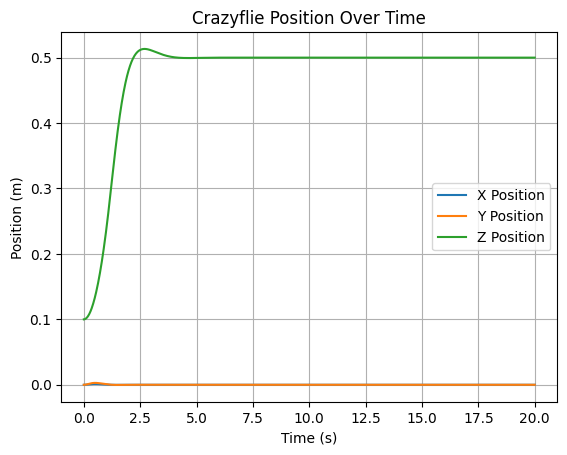

In [141]:
plt.plot(t_l, qpos_l[:, 0], label ="X Position")
plt.plot(t_l, qpos_l[:, 1], label ="Y Position")
plt.plot(t_l, qpos_l[:, 2], label ="Z Position")
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.grid()
plt.title("Crazyflie Position Over Time") 
plt.legend()

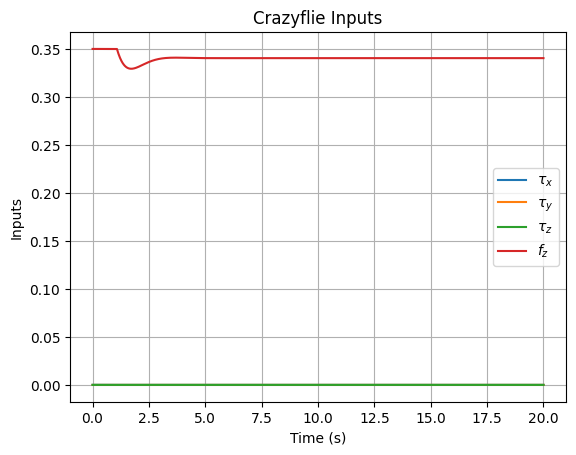

In [142]:
plt.plot(t_l, u_l[:, 0], label=r"$\tau_x$")
plt.plot(t_l, u_l[:, 1], label=r"$\tau_y$")
plt.plot(t_l, u_l[:, 2], label=r"$\tau_z$")
plt.plot(t_l, u_l[:, 3], label=r"$f_z$")
plt.grid()
plt.xlabel("Time (s)")
plt.ylabel("Inputs")
plt.title("Crazyflie Inputs")
plt.legend()

RMS Position Error (m) for the Custom Controller with Perturbations: 0.0862899785332984


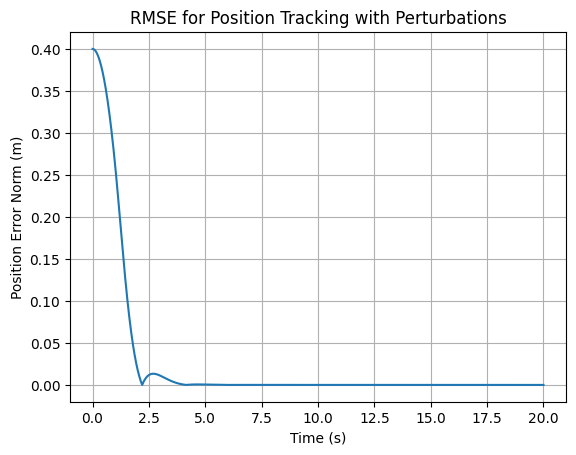

In [143]:
error_norm = np.linalg.norm(qpos_l[:,:3] - desired_pos, axis = 1)
rms_error = np.sqrt(np.mean(error_norm**2))
plt.plot(t_l, error_norm)
plt.xlabel("Time (s)")
plt.ylabel("Position Error Norm (m)")
plt.grid()
plt.title("RMSE for Position Tracking with Perturbations")
print("RMS Position Error (m) for the Custom Controller with Perturbations:", rms_error)

As seen above, the controller from Lab 5 is not robust to perturbations and requires further tuning.

<h1 style="color:navy; text-decoration:underline;">
Adding the Gym Environment
</h1>

In [144]:
# def backflip_reference(t, start_pos=[0.0, 0.0, 0.5], flip_height=1.0, duration=2.0):
#     """Compute backflip reference position and orientation at time t.
    
#     Args:
#         t: float, time in seconds
#         start_pos: list of 3 floats, starting position [x, y, z]
#         flip_height: float, maximum height of the flip
#         duration: float, total duration of the flip in seconds
    
#     Returns:
#         position: np.ndarray of shape (3,)
#         orientation: np.ndarray of shape (3,) in radians (roll, pitch, yaw)
#     """
#     if t < 0 or t > duration:
#         return np.array(start_pos), np.array([0.0, 0.0, 0.0])
    
#     # Vertical position follows a parabolic trajectory
#     if t <= duration / 2:
#         z = start_pos[2] + (4 * flip_height / duration**2) * t * (duration / 2 - t)
#     else:
#         z = start_pos[2]
    
#     position = np.array([start_pos[0], start_pos[1], z])
    
#     # Pitch angle follows a linear trajectory from 0 to 360 degrees
#     pitch = (360.0 / duration) * t
#     # pitch = 0
#     orientation = np.array([0.0, np.radians(pitch), 0.0])  # roll=0, yaw=0
    
#     return position, orientation

# def backflip_reference_trajectory(start_pos=[0.0, 0.0, 0.5], flip_height=1.0, duration=2.0, dt=1/60):
#     """Generate a backflip reference trajectory.
    
#     Returns:
#         times: np.ndarray of shape (N,)
#         positions: np.ndarray of shape (N, 3)
#         orientations: np.ndarray of shape (N, 3)
#     """
    
#     num_steps = int(duration / dt)
#     positions = np.zeros((num_steps, 3))
#     orientations = np.zeros((num_steps, 3))  # roll, pitch, yaw
#     times = np.linspace(0, duration, num_steps)
        
#     for i, t in enumerate(times):
#         pos, ori = backflip_reference(t, start_pos=start_pos, flip_height=flip_height, duration=duration)
#         positions[i] = pos
#         orientations[i] = ori

#     return times, positions, orientations

In [145]:
import numpy as np

def backflip_reference(t, start_pos=[0.0, 0.0, 0.5], flip_height=1.0, duration=2.0):
    """Compute backflip reference position and orientation at time t.

    Args:
        t: float, time in seconds
        start_pos: list of 3 floats, starting position [x, y, z]
        flip_height: float, maximum height gain relative to start
        duration: float, total duration of the flip in seconds

    Returns:
        position: np.ndarray of shape (3,)
        orientation: np.ndarray of shape (3,) in radians (roll, pitch, yaw)
    """
    if t < 0:
        return np.array(start_pos), np.array([0.0, 0.0, 0.0])
    elif t > duration:
        # return to start position and orientation
        return np.array(start_pos), np.array([0.0, 0.0, 0.0])
    
    # normalized time from 0 to 1
    tau = t / duration

    # Parabolic vertical trajectory: z = z0 + 4h * tau * (1 - tau)
    z = start_pos[2] + 4 * flip_height * tau * (1 - tau)

    # Constant x,y (stationary flip)
    x, y = start_pos[0], start_pos[1]

    # Pitch angle rotates full 360° backward (negative direction)
    pitch = -2 * np.pi * tau  # radians

    position = np.array([x, y, z])
    orientation = np.array([0.0, pitch, 0.0])  # roll=0, yaw=0

    return position, orientation


def backflip_reference_trajectory(start_pos=[0.0, 0.0, 0.5], flip_height=1.0, duration=2.0, dt=1/60):
    """Generate a backflip reference trajectory.

    Returns:
        times: np.ndarray of shape (N,)
        positions: np.ndarray of shape (N, 3)
        orientations: np.ndarray of shape (N, 3)
    """
    times = np.arange(0, duration + dt, dt)
    positions = np.zeros((len(times), 3))
    orientations = np.zeros((len(times), 3))

    for i, t in enumerate(times):
        pos, ori = backflip_reference(t, start_pos=start_pos, flip_height=flip_height, duration=duration)
        positions[i] = pos
        orientations[i] = ori

    return times, positions, orientations


In [146]:
ref_traj = backflip_reference_trajectory(duration = 20.0)
times, positions, orientations = ref_traj

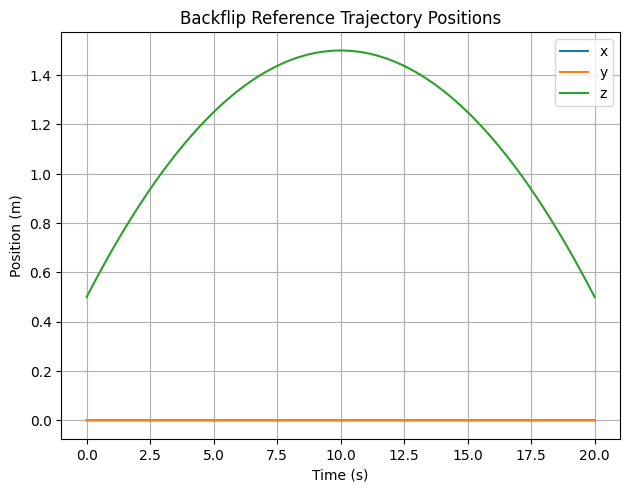

In [95]:
plt.plot(times, positions[:,0], label = "x")
plt.plot(times, positions[:,1], label = "y")
plt.plot(times, positions[:,2], label = "z")
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.grid()
plt.legend()
plt.tight_layout()
plt.title("Backflip Reference Trajectory Positions")
plt.show()

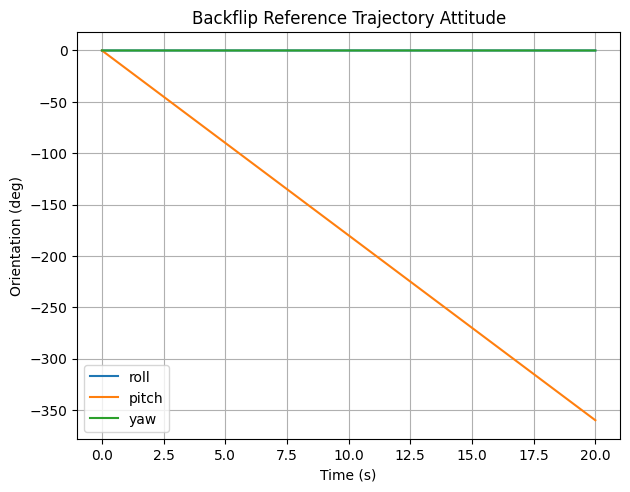

In [96]:
plt.plot(times, np.degrees(orientations[:,0]), label = "roll")
plt.plot(times, np.degrees(orientations[:,1]), label = "pitch")
plt.plot(times, np.degrees(orientations[:,2]), label = "yaw")
plt.xlabel("Time (s)")
plt.ylabel("Orientation (deg)")
plt.grid()
plt.legend()
plt.tight_layout()
plt.title("Backflip Reference Trajectory Attitude")
plt.show()

In [97]:
class BackflipEnv(gym.Env):
    mg = 0.340407
    torque_scaling = 1
    action_space = gym.spaces.Box(low=np.array(3*[-torque_scaling] + [-mg]), high=np.array(3*[torque_scaling] + [0.35-mg]), shape=(4,), dtype=np.float32)
        
    obs_low = np.array([-np.inf]*12)
    obs_low[2] = 0.0  # z position must be non-negative
    obs_low[6:9] = -np.pi  # roll, pitch, yaw
    obs_high = np.array([np.inf]*12)
    obs_high[6:9] = np.pi  # roll, pitch, yaw
    observation_space = gym.spaces.Box(low=obs_low, high=obs_high, shape=(12,), dtype=np.float32)
    
    def __init__(self, start_position=[0.0, 0.0, 0.5], duration=10.0, flip_duration=4.0, dt=1/60, perturb_initial=True):
        super(BackflipEnv, self).__init__()
        self.duration = duration
        self.flip_duration = flip_duration
        self.dt = dt
        self.model = mujoco.MjModel.from_xml_path("mujoco_menagerie/bitcraze_crazyflie_2/cf2.xml")
        self.data = mujoco.MjData(self.model)
        self.current_step = 0
        self.num_steps = int(self.duration / self.dt)
        self.data.qpos[0:3] = np.array(start_position)
        self.start_pos = self.data.qpos[0:3].copy()
        
        self.perturb_initial = perturb_initial
        if self.perturb_initial:
            self.perturb_initial_state()
            
        mujoco.mj_forward(self.model, self.data)
        
    def render(self, mode='human'):
        with mujoco.Renderer(self.model, height=480, width=640) as renderer:
            renderer.update_scene(self.data, camera='track')
            pixels = renderer.render()
            return pixels
            
    def reset(self, *, seed = None, options = None):
        super().reset(seed=seed)
        mujoco.mj_resetData(self.model, self.data)
        self.data.qpos[0:3] = self.start_pos.copy()
        if self.perturb_initial:
            self.perturb_initial_state()
        self.current_step = 0
        return self.get_state(), {}

    def step(self, action):
        action = enforce_motor_limits(action)
        self.data.actuator('x_moment').ctrl = action[0] * -1e5
        self.data.actuator('y_moment').ctrl = action[1] * -1e5
        self.data.actuator('z_moment').ctrl = action[2] * -1e5
        self.data.actuator('body_thrust').ctrl = action[3] + BackflipEnv.mg
        
        while self.data.time < (self.current_step + 1) * self.dt:
            mujoco.mj_step(self.model, self.data)

        self.current_step += 1
        
        state = self.get_state()
        reward = self.compute_reward()
        terminated = self.current_step >= self.num_steps
        truncated = self.has_crashed()
        
        return state, reward, terminated, truncated, {}
    
    def has_crashed(self):
        return self.data.qpos[2] < 0.01
            
    def get_state(self):
        pos = self.data.qpos[0:3].copy()
        ori = R.from_quat(self.data.qpos[3:7], scalar_first=True).as_euler('xyz')
        vel = self.data.qvel[0:3].copy()
        ang_vel = self.data.qvel[3:6].copy()
        return np.concatenate([pos, ori, vel, ang_vel])
            
    def get_reference(self, t):
        pos, ori = backflip_reference(t, start_pos=self.start_pos, flip_height=1.0, duration=self.flip_duration)
        return pos, ori
    
    def get_tracking_error(self):
        t = self.current_step * self.dt
        ref_pos, ref_ori = self.get_reference(t)
        current_pos = self.data.qpos[0:3]
        current_ori = R.from_quat(self.data.qpos[3:7], scalar_first=True).as_euler('xyz')
        
        pos_error = np.abs(current_pos - ref_pos)
        ori_error = np.abs(current_ori - ref_ori)
        
        return pos_error, ori_error
    
    def compute_reward(self):
        pos_error, ori_error = self.get_tracking_error()
        reward = - np.sum(pos_error + ori_error) # added a term to scale ori_error
        return reward
            
    def perturb_initial_state(self):
        angles = np.random.uniform(-0.001, 0.001, size=3)
        rot = R.from_euler('xyz', angles)
        current_rot = R.from_quat(self.data.qpos[3:7], scalar_first=True)
        new_rot = rot * current_rot
        self.data.qpos[3:7] = new_rot.as_quat(scalar_first=True)


/Users/aaliyahgaffey/483_RL/.conda/lib/python3.11/site-packages/gymnasium/spaces/box.py:236: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/aaliyahgaffey/483_RL/.conda/lib/python3.11/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


In [98]:
env = BackflipEnv(perturb_initial=False, flip_duration=20.0, duration=20.0)
ddpg = DDPG("MlpPolicy", env, verbose=1)
ddpg.learn(total_timesteps=500_000)  # adjust timesteps as needed

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 1.2e+03   |
|    ep_rew_mean     | -1.71e+04 |
| time/              |           |
|    episodes        | 4         |
|    fps             | 260       |
|    time_elapsed    | 18        |
|    total_timesteps | 4800      |
| train/             |           |
|    actor_loss      | 163       |
|    critic_loss     | 89.3      |
|    learning_rate   | 0.001     |
|    n_updates       | 4699      |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 1.2e+03   |
|    ep_rew_mean     | -1.77e+04 |
| time/              |           |
|    episodes        | 8         |
|    fps             | 261       |
|    time_elapsed    | 36        |
|    total_timesteps | 9600      |
| train/             |           |
|    actor_loss      | 379     

KeyboardInterrupt: 

In [ ]:
env.get_state()

array([ 0.32261064, -0.1226545 ,  0.49934327,  0.00383134,  0.00889188,
       -0.00910757,  0.19191653, -0.07714592, -0.00058857,  0.00145167,
        0.00252266, -0.00273446])

In [ ]:
ddpg.predict(env.get_state(), deterministic=True)

(array([ 0.001     , -0.001     ,  0.001     ,  0.00959301], dtype=float32),
 None)

In [ ]:
vec_env.render(mode='human')

In [ ]:
env = BackflipEnv(perturb_initial=False)
env.render_mode = 'human'

vec_env = BackflipEnv(perturb_initial=False)
obs, _ = vec_env.reset()
vec_env.render_mode = 'human'
frames = []

for _ in range(vec_env.num_steps):
    action, _states = ddpg.predict(obs, deterministic=True)
    obs, rewards, dones, truncated, info = vec_env.step(action)
    frame = vec_env.render(mode = 'human')
    frames.append(frame)

env.close()
media.show_video(frames, fps=60)